In [1]:
import Pkg; Pkg.activate(@__DIR__)
include("taylorseries.jl")
using Test
using Symbolics
using SparseArrays
using BenchmarkTools 

  Activating project at `~/.julia/dev/BilinearControl/examples`


In [2]:
# Define the dynamics
function pendulum_dynamics(states, controls)
    x = states[1]
    xdot = states[2]
    tau = controls[1]
    a = -2.1 # g / J⋅ℓ
    b = 0.1  # damping / J
    c = 0.5  # 1/J
    xddot = a * sin(x)  + b * xdot  + c*tau
    return [xdot, xddot]
end

# Build state and control vectors
@variables t x(t) τ
Dt = Differential(t)
xdot = Dt(x)
ẋ = xdot
states = [x, xdot]
controls = [τ];

In [3]:
# Get symbolic expression for dynamics
statederivative = pendulum_dynamics(states, controls)

2-element Vector{Num}:
 Differential(t)(x(t))
  0.5τ + 0.1Differential(t)(x(t)) - 2.1sin(x(t))

In [4]:
# Get Taylor series approximation of dynamics
order = 3
states0 = [Symbolics.variable(Symbol("_x0"), i) for i = 1:length(states)]
approx_dynamics = map(statederivative) do xdot
    Num(taylorexpand(xdot, states, states0, order))
end

2-element Vector{Num}:
 Differential(t)(x(t))
  0.5τ + 0.1Differential(t)(x(t)) + 1.05((x(t) - _x0₁)^2)*sin(_x0₁) + 0.35((x(t) - _x0₁)^3)*cos(_x0₁) - 2.1sin(_x0₁) - 2.1(x(t) - _x0₁)*cos(_x0₁)

In [5]:
# Build expanded state vector
y = buildstatevector(states, 3)

9-element Vector{Num}:
        x(t)
          Differential(t)(x(t))
      x(t)^2
     x(t)*Differential(t)(x(t))
          Differential(t)(x(t))^2
      x(t)^3
 (x(t)^2)*Differential(t)(x(t))
         (Differential(t)(x(t))^2)*x(t)
          Differential(t)(x(t))^3

In [6]:
# Form expanded state derivative
ydot = expand_derivatives.(Dt.(y))

9-element Vector{Num}:
           Differential(t)(x(t))
           Differential(t)(Differential(t)(x(t)))
     2x(t)*Differential(t)(x(t))
      x(t)*Differential(t)(Differential(t)(x(t))) + Differential(t)(x(t))^2
          2Differential(t)(x(t))*Differential(t)(Differential(t)(x(t)))
 3(x(t)^2)*Differential(t)(x(t))
  (x(t)^2)*Differential(t)(Differential(t)(x(t))) + 2(Differential(t)(x(t))^2)*x(t)
           Differential(t)(x(t))^3 + 2x(t)*Differential(t)(x(t))*Differential(t)(Differential(t)(x(t)))
         3(Differential(t)(x(t))^2)*Differential(t)(Differential(t)(x(t)))

In [7]:
# Substitute in the approximate dynamics
subs = Dict(Dt(states[i])=>approx_dynamics[i] for i = 1:length(states))
ydot_approx = map(ydot) do yi
    substitute(yi, subs)
end

9-element Vector{Num}:
           Differential(t)(x(t))
            0.5τ + 0.1Differential(t)(x(t)) + 1.05((x(t) - _x0₁)^2)*sin(_x0₁) + 0.35((x(t) - _x0₁)^3)*cos(_x0₁) - 2.1sin(_x0₁) - 2.1(x(t) - _x0₁)*cos(_x0₁)
     2x(t)*Differential(t)(x(t))
           (0.5τ + 0.1Differential(t)(x(t)) + 1.05((x(t) - _x0₁)^2)*sin(_x0₁) + 0.35((x(t) - _x0₁)^3)*cos(_x0₁) - 2.1sin(_x0₁) - 2.1(x(t) - _x0₁)*cos(_x0₁))*x(t) + Differential(t)(x(t))^2
          2(0.5τ + 0.1Differential(t)(x(t)) + 1.05((x(t) - _x0₁)^2)*sin(_x0₁) + 0.35((x(t) - _x0₁)^3)*cos(_x0₁) - 2.1sin(_x0₁) - 2.1(x(t) - _x0₁)*cos(_x0₁))*Differential(t)(x(t))
 3(x(t)^2)*Differential(t)(x(t))
           (0.5τ + 0.1Differential(t)(x(t)) + 1.05((x(t) - _x0₁)^2)*sin(_x0₁) + 0.35((x(t) - _x0₁)^3)*cos(_x0₁) - 2.1sin(_x0₁) - 2.1(x(t) - _x0₁)*cos(_x0₁))*(x(t)^2) + 2(Differential(t)(x(t))^2)*x(t)
           Differential(t)(x(t))^3 + 2(0.5τ + 0.1Differential(t)(x(t)) + 1.05((x(t) - _x0₁)^2)*sin(_x0₁) + 0.35((x(t) - _x0₁)^3)*cos(_x0₁) - 2.1sin(_x0₁) -

In [8]:
# Build symbolic sparse matrices
Asym = getAsym(ydot_approx, y, controls)
Bsym = getBsym(ydot_approx, y, controls)
Csym = getCsym(ydot_approx, y, controls)
Dsym = getDsym(ydot_approx, y, controls);

In [9]:
Asym

9×9 SparseMatrixCSC{Num, Int64} with 27 stored entries:
 ⋅                                                                                   …  ⋅
 1.05(_x0₁^2)*cos(_x0₁) - 2.1cos(_x0₁) - 2.1_x0₁*sin(_x0₁)                              ⋅
 ⋅                                                                                      ⋅
 2.1_x0₁*cos(_x0₁) + 1.05(_x0₁^2)*sin(_x0₁) - 2.1sin(_x0₁) - 0.35(_x0₁^3)*cos(_x0₁)     ⋅
 ⋅                                                                                      ⋅
 ⋅                                                                                   …  ⋅
 ⋅                                                                                      ⋅
 ⋅                                                                                      1
 ⋅                                                                                      0.3

In [10]:
# Build expressions for updating A,B,C,D
updateA_expr, updateB_expr, updateC_expr, updateD_expr = 
    build_bilinear_dynamics_functions(Asym, Bsym, Csym, Dsym, states0, controls);

In [11]:
updateA_expr

quote
    #= /home/brian/.julia/dev/BilinearControl/examples/taylorseries.jl:380 =#
    function (A, x0)
        #= /home/brian/.julia/dev/BilinearControl/examples/taylorseries.jl:380 =#
        #= /home/brian/.julia/dev/BilinearControl/examples/taylorseries.jl:381 =#
        _x0 = x0
        #= /home/brian/.julia/dev/BilinearControl/examples/taylorseries.jl:383 =#
        nzval = A.nzval
        #= /home/brian/.julia/dev/BilinearControl/examples/taylorseries.jl:384 =#
        nzval[1] = (+)((+)((*)(-2.1, (cos)((getindex)(_x0, 1))), (*)((*)(1.0499999999999998, (^)((getindex)(_x0, 1), 2)), (cos)((getindex)(_x0, 1)))), (*)((*)(-2.1, (sin)((getindex)(_x0, 1))), (getindex)(_x0, 1)))
        nzval[2] = (+)((+)((+)((*)(-2.1, (sin)((getindex)(_x0, 1))), (*)((*)(1.05, (^)((getindex)(_x0, 1), 2)), (sin)((getindex)(_x0, 1)))), (*)((*)(-0.35, (^)((getindex)(_x0, 1), 3)), (cos)((getindex)(_x0, 1)))), (*)((*)(2.1, (cos)((getindex)(_x0, 1))), (getindex)(_x0, 1)))
        nzval[3] = 1
        nzval[4

In [12]:
# Evaluate the expressions to build the functions
pendulum_updateA! = eval(updateA_expr)
pendulum_updateB! = eval(updateB_expr)
pendulum_updateC! = eval(updateC_expr)
pendulum_updateD! = eval(updateD_expr);
# pendulum_expand! = eval(state_expand_expr)

In [13]:
# Build the function to build the expanded state vector
state_expand_expr = build_expanded_vector_function(y)
pendulum_expand! = eval(state_expand_expr);

In [14]:
# Test the dynamics
x0_ = zeros(length(states))
x_ = [deg2rad(30), deg2rad(10)]
y_ = zeros(length(y))
u_ = [0.5]
pendulum_expand!(y_, x_)

# Create matrices 
A = similar(Asym, Float64)
B = similar(Bsym, Float64)
C = [similar(C, Float64) for C in Csym]
D = similar(Dsym, Float64)

# Update matrices (updates the nonzeros vector directly)
pendulum_updateA!(A, x0_)
pendulum_updateB!(B, x0_)
pendulum_updateC!(C, x0_)
pendulum_updateD!(D, x0_)

ydot_ = A*y_ + B*u_ + u_[1]*C[1]*y_ + D
xdot1 = ydot_[1:2]
xdot0 = pendulum_dynamics(x_, u_)
norm(xdot1 - xdot0)

0.0006842232718358154

In [18]:
using Plots

In [19]:
thetas = range(-pi,pi,length=101)
X = [[theta; 0] for theta in thetas]
u = [0.5]
x0 = zeros(2);

In [30]:
order = 3
@time bilinear_pendulum = bilinearize_dynamics(pendulum_dynamics, states, controls, t, order)

state_expand_expr = build_expanded_vector_function(bilinear_pendulum)

updateA_expr, updateB_expr, updateC_expr, updateD_expr = 
    build_bilinear_dynamics_functions(bilinear_pendulum)

_pendulum_updateA! = eval(updateA_expr)
_pendulum_updateB! = eval(updateB_expr)
_pendulum_updateC! = eval(updateC_expr)
_pendulum_updateD! = eval(updateD_expr)
_pendulum_expand! = eval(state_expand_expr)

A = similar(bilinear_pendulum.A, Float64)
B = similar(bilinear_pendulum.B, Float64)
C = [similar(C, Float64) for C in bilinear_pendulum.C]
D = similar(bilinear_pendulum.D, Float64)

# Update matrices
y = zeros(bilinear_pendulum.n)
err3 = map(X) do x
    _pendulum_expand!(y, x)
    _pendulum_updateA!(A, x0)
    _pendulum_updateB!(B, x0)
    _pendulum_updateC!(C, x0)
    _pendulum_updateD!(D, x0)
    ydot = A*y + B*u + u[1]*C[1]*y + D
    xdot1 = ydot[1:2]
    xdot0 = pendulum_dynamics(x, u)
    norm(xdot1 - xdot0)
end;

  0.264967 seconds (2.49 M allocations: 95.274 MiB, 8.35% gc time, 19.65% compilation time)


In [24]:
order = 5
@time bilinear_pendulum = bilinearize_dynamics(pendulum_dynamics, states, controls, t, order)

state_expand_expr = build_expanded_vector_function(bilinear_pendulum)

updateA_expr, updateB_expr, updateC_expr, updateD_expr = 
    build_bilinear_dynamics_functions(bilinear_pendulum)

_pendulum_updateA! = eval(updateA_expr)
_pendulum_updateB! = eval(updateB_expr)
_pendulum_updateC! = eval(updateC_expr)
_pendulum_updateD! = eval(updateD_expr)
_pendulum_expand! = eval(state_expand_expr)

A = similar(bilinear_pendulum.A, Float64)
B = similar(bilinear_pendulum.B, Float64)
C = [similar(C, Float64) for C in bilinear_pendulum.C]
D = similar(bilinear_pendulum.D, Float64)

# Update matrices
y = zeros(bilinear_pendulum.n)
err5 = map(X) do x
    _pendulum_expand!(y, x)
    _pendulum_updateA!(A, x0)
    _pendulum_updateB!(B, x0)
    _pendulum_updateC!(C, x0)
    _pendulum_updateD!(D, x0)
    ydot = A*y + B*u + u[1]*C[1]*y + D
    xdot1 = ydot[1:2]
    xdot0 = pendulum_dynamics(x, u)
    norm(xdot1 - xdot0)
end;

  2.561320 seconds (30.08 M allocations: 1.109 GiB, 8.50% gc time, 5.69% compilation time)


In [25]:
order = 7
@time bilinear_pendulum = bilinearize_dynamics(pendulum_dynamics, states, controls, t, order)

state_expand_expr = build_expanded_vector_function(bilinear_pendulum)

updateA_expr, updateB_expr, updateC_expr, updateD_expr = 
    build_bilinear_dynamics_functions(bilinear_pendulum)

_pendulum_updateA! = eval(updateA_expr)
_pendulum_updateB! = eval(updateB_expr)
_pendulum_updateC! = eval(updateC_expr)
_pendulum_updateD! = eval(updateD_expr)
_pendulum_expand! = eval(state_expand_expr)

A = similar(bilinear_pendulum.A, Float64)
B = similar(bilinear_pendulum.B, Float64)
C = [similar(C, Float64) for C in bilinear_pendulum.C]
D = similar(bilinear_pendulum.D, Float64)

# Update matrices
y = zeros(bilinear_pendulum.n)
err7 = map(X) do x
    _pendulum_expand!(y, x)
    _pendulum_updateA!(A, x0)
    _pendulum_updateB!(B, x0)
    _pendulum_updateC!(C, x0)
    _pendulum_updateD!(D, x0)
    ydot = A*y + B*u + u[1]*C[1]*y + D
    xdot1 = ydot[1:2]
    xdot0 = pendulum_dynamics(x, u)
    norm(xdot1 - xdot0)
end;

 15.892231 seconds (208.14 M allocations: 7.470 GiB, 9.58% gc time, 2.93% compilation time)


In [32]:
order = 9
@time bilinear_pendulum = bilinearize_dynamics(pendulum_dynamics, states, controls, t, order)

state_expand_expr = build_expanded_vector_function(bilinear_pendulum)

updateA_expr, updateB_expr, updateC_expr, updateD_expr = 
    build_bilinear_dynamics_functions(bilinear_pendulum)

_pendulum_updateA! = eval(updateA_expr)
_pendulum_updateB! = eval(updateB_expr)
_pendulum_updateC! = eval(updateC_expr)
_pendulum_updateD! = eval(updateD_expr)
_pendulum_expand! = eval(state_expand_expr)

A = similar(bilinear_pendulum.A, Float64)
B = similar(bilinear_pendulum.B, Float64)
C = [similar(C, Float64) for C in bilinear_pendulum.C]
D = similar(bilinear_pendulum.D, Float64)

# Update matrices
y = zeros(bilinear_pendulum.n)
err9 = map(X) do x
    _pendulum_expand!(y, x)
    _pendulum_updateA!(A, x0)
    _pendulum_updateB!(B, x0)
    _pendulum_updateC!(C, x0)
    _pendulum_updateD!(D, x0)
    ydot = A*y + B*u + u[1]*C[1]*y + D
    xdot1 = ydot[1:2]
    xdot0 = pendulum_dynamics(x, u)
    norm(xdot1 - xdot0)
end;

 52.983048 seconds (732.22 M allocations: 27.178 GiB, 10.35% gc time, 0.14% compilation time)


In [28]:
A9 = copy(A)

54×54 SparseMatrixCSC{Float64, Int64} with 299 stored entries:
⡚⣢⣐⠀⢐⠀⠀⡂⠀⠀⡂⠀⠀⢐⠀⠀⠀⢐⠀⠀⠀⠀⡂⠀⠀⠀⠀
⠈⢌⠡⣧⡠⡁⠀⢌⠀⠀⢌⠀⠀⠠⡁⠀⠀⠠⡁⠀⠀⠀⢌⠀⠀⠀⠀
⠀⠀⠡⡈⠡⣮⡀⢄⠁⠀⢄⠁⠀⠠⡈⠀⠀⠠⡈⠀⠀⠀⢄⠁⠀⠀⠀
⠀⠀⠀⠈⢂⠈⠛⣠⡑⠀⡀⠑⠀⢀⠈⠂⠀⢀⠈⠂⠀⠀⡀⠑⠀⠀⠀
⠀⠀⠀⠀⠀⠑⢄⠈⠻⣦⠈⠢⡀⠀⠑⢄⠀⠀⠑⢄⠀⠀⠈⠢⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠢⡀⠀⠺⣦⡀⠐⢄⠀⠀⠐⢄⠀⠀⠀⠢⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⠀⠈⠻⠆⡀⠑⠄⠀⠀⠑⠄⠀⠀⠈⠢⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠈⠻⣦⡀⠈⠢⡀⠀⠀⠑⢄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠄⠀⠈⠻⠆⡀⠈⠢⠀⠀⠀⠑⠄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠀⠈⠻⣦⡀⠀⠑⢄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠀⠈⠻⣦⠀⠀⠑⢄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⢄⠀⠀⠀⠺⣦⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠻⣦⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠀⠀⠀⠈⠛

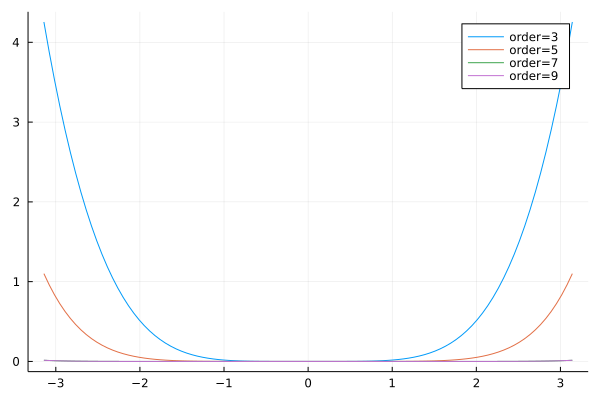

In [33]:
plot(thetas, err3, label="order=3")
plot!(thetas, err5, label="order=5")
plot!(thetas, err7, label="order=7")
plot!(thetas, err9, label="order=9")

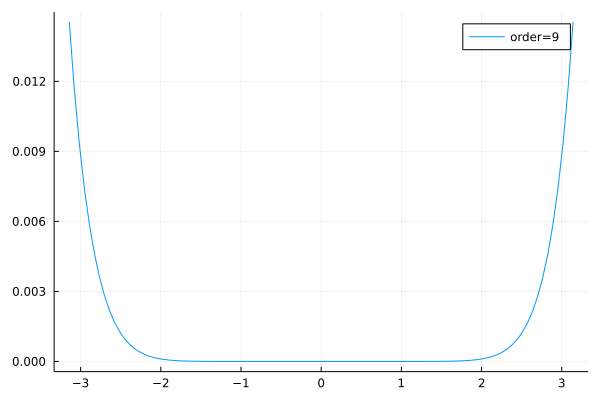

In [35]:
plot(thetas, err9, label="order=9")